In [8]:
import pandas as pd

In [2]:
df=pd.read_csv("data.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'Date', 'Tweet Count', 'Username', 'Text', 'Created At',
       'Retweets', 'Likes', 'stockname', 'clean_text', 'sentiment_score'],
      dtype='object')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Sentiment score distribution

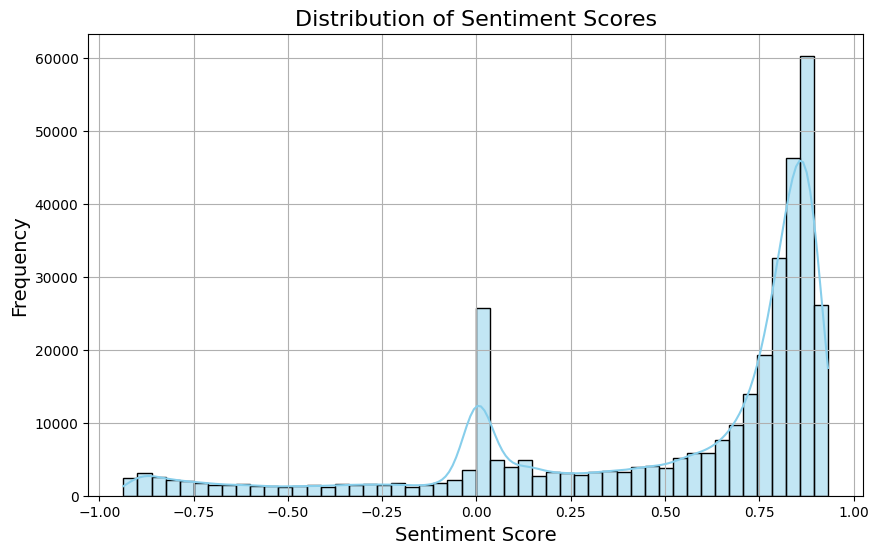

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(df['sentiment_score'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

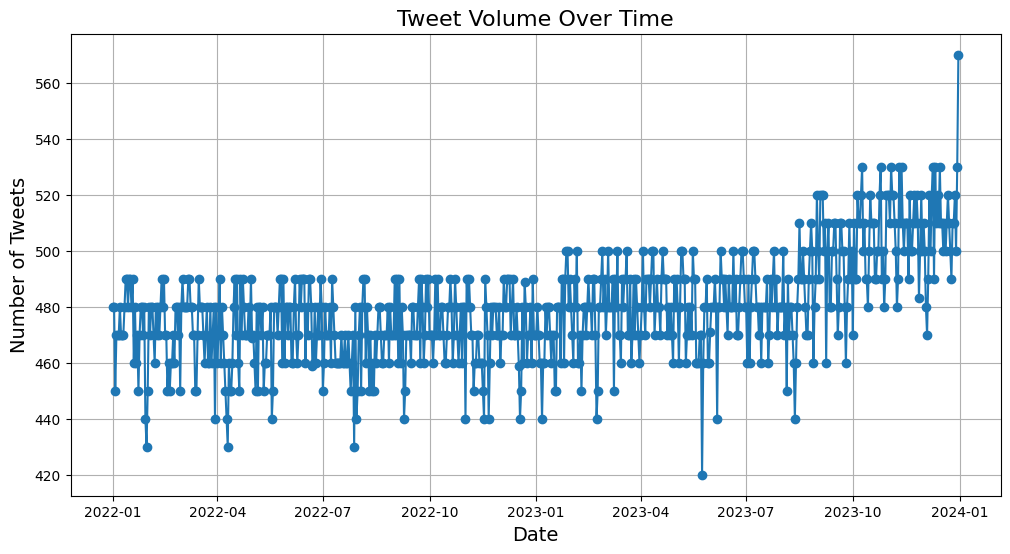

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

daily_tweet_counts = df.groupby('Date').size().reset_index(name='Tweet Count')

plt.figure(figsize=(12,6))
plt.plot(daily_tweet_counts['Date'], daily_tweet_counts['Tweet Count'], marker='o', linestyle='-')
plt.title('Tweet Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.grid(True)
plt.show()

## Tweet volume over time

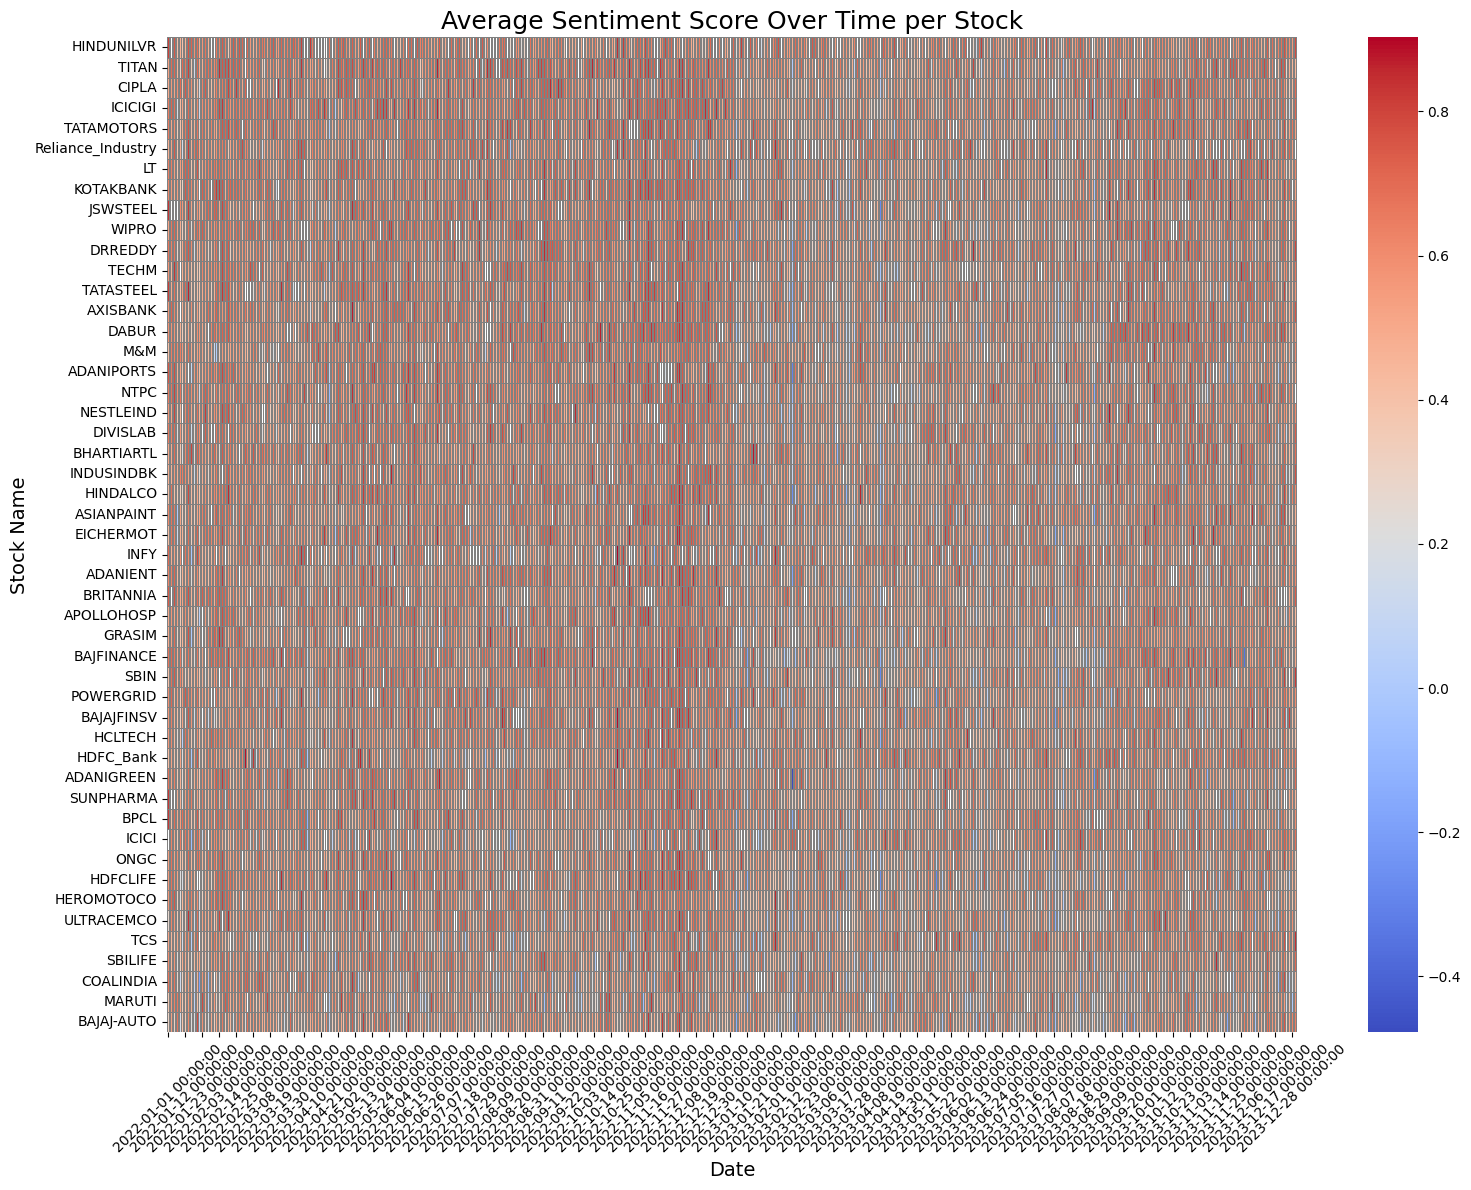

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate average sentiment score per day for each stock
sentiment_over_time = df.groupby(['Date', 'stockname'])['sentiment_score'].mean().reset_index()

# Pivot the data to have stock names as rows and dates as columns
pivot_df = sentiment_over_time.pivot(index='stockname', columns='Date', values='sentiment_score')

# Sort the stocks by the average sentiment score (optional)
pivot_df['Average_Sentiment'] = pivot_df.mean(axis=1)
pivot_df.sort_values('Average_Sentiment', ascending=False, inplace=True)
pivot_df.drop('Average_Sentiment', axis=1, inplace=True)

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(pivot_df, cmap='coolwarm', linewidths=0.5, linecolor='gray')

plt.title('Average Sentiment Score Over Time per Stock', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Name', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Get the top 10 users by tweet count

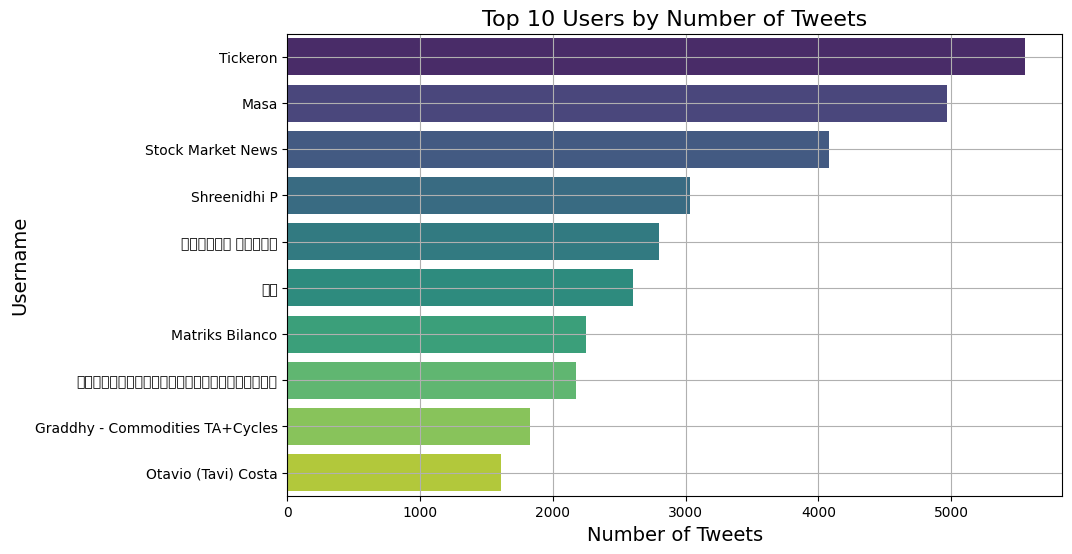

In [8]:
import warnings
warnings.filterwarnings("ignore")
top_users = df['Username'].value_counts().nlargest(10).reset_index()
top_users.columns = ['Username', 'Tweet Count']

plt.figure(figsize=(10,6))
sns.barplot(x='Tweet Count', y='Username', data=top_users, palette='viridis')
plt.title('Top 10 Users by Number of Tweets', fontsize=16)
plt.xlabel('Number of Tweets', fontsize=14)
plt.ylabel('Username', fontsize=14)
plt.grid(True)
plt.show()

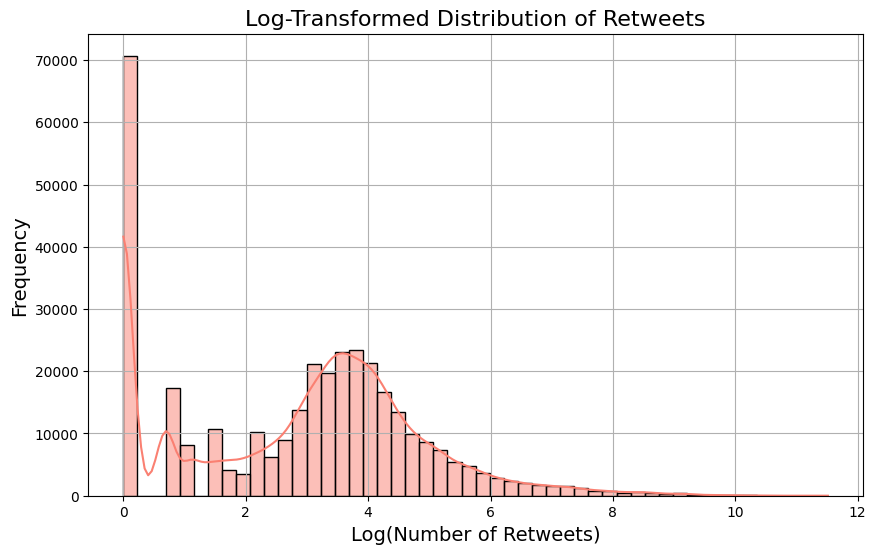

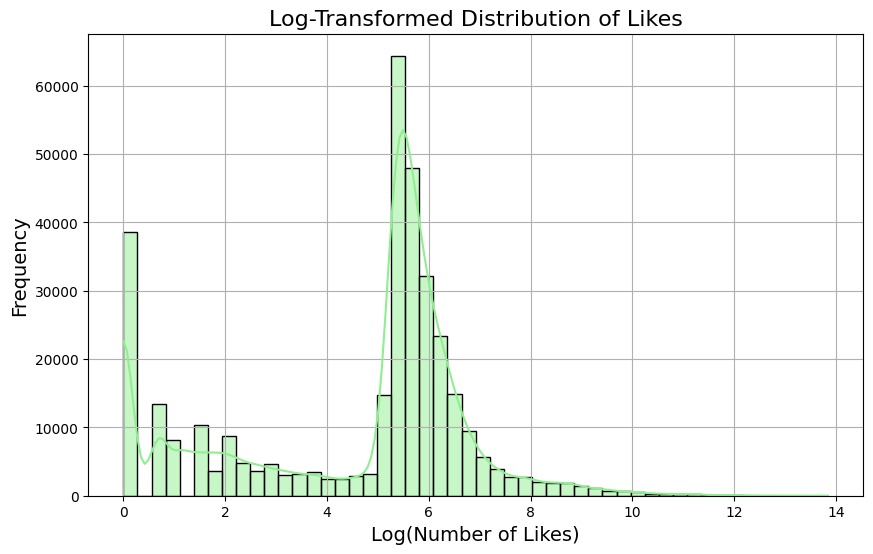

In [9]:
import numpy as np
# Log-transform Retweets and Likes to handle skewness
df['Retweets_log'] = df['Retweets'].apply(lambda x: np.log1p(x))
df['Likes_log'] = df['Likes'].apply(lambda x: np.log1p(x))

# Plot distribution of log-transformed Retweets
plt.figure(figsize=(10,6))
sns.histplot(df['Retweets_log'], bins=50, kde=True, color='salmon')
plt.title('Log-Transformed Distribution of Retweets', fontsize=16)
plt.xlabel('Log(Number of Retweets)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# Plot distribution of log-transformed Likes
plt.figure(figsize=(10,6))
sns.histplot(df['Likes_log'], bins=50, kde=True, color='lightgreen')
plt.title('Log-Transformed Distribution of Likes', fontsize=16)
plt.xlabel('Log(Number of Likes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

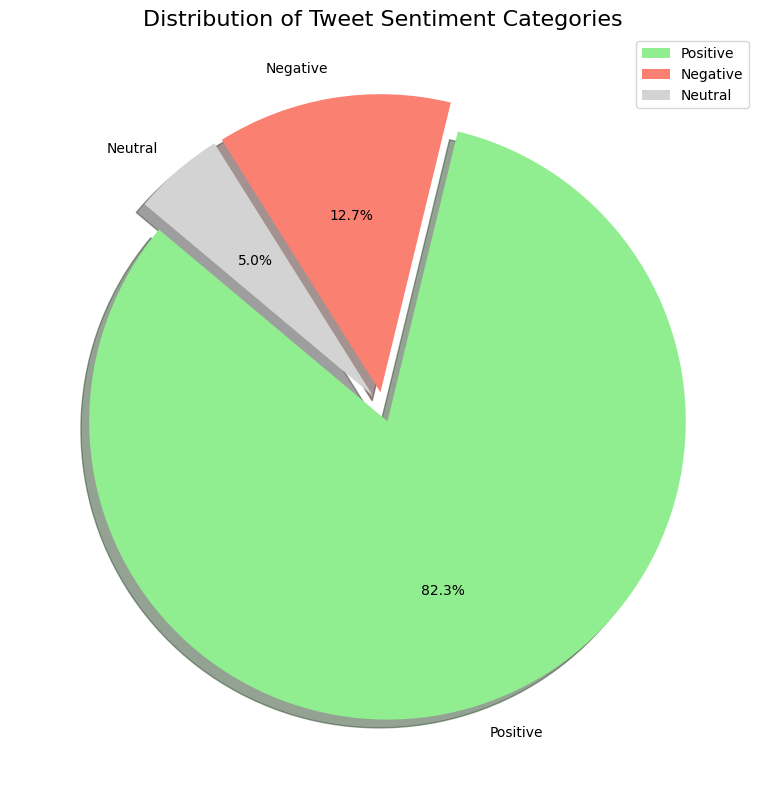

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Define a function to categorize sentiment scores
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to create a new column 'Sentiment Category'
df['Sentiment Category'] = df['sentiment_score'].apply(categorize_sentiment)

# Calculate the counts for each sentiment category
sentiment_counts = df['Sentiment Category'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8,8))
colors = ['lightgreen', 'salmon', 'lightgray']  # Colors for Positive, Negative, Neutral
sentiment_counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    explode=(0.05, 0.05, 0.05),  # Slightly "explode" each slice for emphasis
    shadow=True
)

plt.title('Distribution of Tweet Sentiment Categories', fontsize=16)
plt.ylabel('')  # Hide y-axis label for clarity
plt.legend(labels=sentiment_counts.index, loc='upper right')
plt.tight_layout()
plt.show()

## Fixing Data Imbalance

In [6]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('data.csv')

# Add an index column to keep track of original samples
data.reset_index(inplace=True)
data.rename(columns={'index': 'original_index'}, inplace=True)

# Binning sentiment scores into "positive", "neutral", and "negative"
def categorize_sentiment(score):
    if score > 0.6:
        return 'positive'
    elif score < 0.4:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment binning
data['sentiment_category'] = data['sentiment_score'].apply(categorize_sentiment)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

# List of categorical columns (including 'sentiment_category')
categorical_columns = ['sentiment_category']  # Add your other categorical columns here
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Define the target variable
data['sentiment_category_encoded'] = data['sentiment_category']
le_target = label_encoders['sentiment_category']

# Select features for SMOTENC
features = data.columns.drop(['sentiment_category', 'sentiment_category_encoded', 'sentiment_score', 'original_index', 'Text'])  # Exclude non-feature columns

# Identify indices of categorical features
categorical_feature_mask = data[features].dtypes == object
categorical_features_indices = np.where(categorical_feature_mask)[0]

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    data[features], data['sentiment_category_encoded'], data['original_index'],
    test_size=0.3, random_state=42, stratify=data['sentiment_category_encoded']
)

# Apply SMOTENC
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(
    categorical_features=categorical_features_indices,
    random_state=42
)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

# Map resampled data back to original DataFrame
n_original_samples = len(X_train)
n_resampled_samples = len(X_resampled)
n_synthetic_samples = n_resampled_samples - n_original_samples

# Create a DataFrame for X_resampled
X_resampled_df = pd.DataFrame(X_resampled, columns=features)

# Add the target variable
X_resampled_df['sentiment_category_encoded'] = y_resampled

# Identify synthetic samples
X_resampled_df['is_synthetic'] = True
X_resampled_df.iloc[:n_original_samples, X_resampled_df.columns.get_loc('is_synthetic')] = False

# For original samples, map back the original indices
X_resampled_df['original_index'] = None
X_resampled_df.iloc[:n_original_samples, X_resampled_df.columns.get_loc('original_index')] = idx_train.values

# Retrieve original samples with all columns
original_samples = X_resampled_df[X_resampled_df['is_synthetic'] == False]
original_data = data.loc[original_samples['original_index'].astype(int)].copy()

# Update the features with any changes from resampling (if any)
for col in features:
    original_data[col] = original_samples[col].values

# For synthetic samples, create a DataFrame with NaN for non-included features
synthetic_samples = X_resampled_df[X_resampled_df['is_synthetic'] == True].copy()
synthetic_data = synthetic_samples.copy()

# Assign NaN to non-included features
non_included_features = ['sentiment_score', 'Text', 'original_index']  # Add any features not included in SMOTE
for col in non_included_features:
    synthetic_data[col] = np.nan

# Combine original and synthetic data
resampled_data = pd.concat([original_data, synthetic_data], ignore_index=True, sort=False)

# Decode categorical features
for col in categorical_columns:
    le = label_encoders[col]
    resampled_data[col] = le.inverse_transform(resampled_data[col].astype(int))

# Save the resampled dataset
resampled_data.to_csv('resampled_data.csv', index=False)



    precision    recall  f1-score   support

    negative       0.62      0.75      0.68     31,420
     neutral       0.29      0.71      0.41      7,337
    positive       0.89      0.65      0.75     66,239

    accuracy                           0.69    104,996
   macro avg       0.60      0.71      0.61    104,996
Resampled dataset saved as 'resampled_data.csv'


In [9]:
b=pd.read_csv("balanced_data.csv")

In [13]:
b.sentiment_category.value_counts()

sentiment_category
positive    220797
neutral     220797
negative    220797
Name: count, dtype: int64

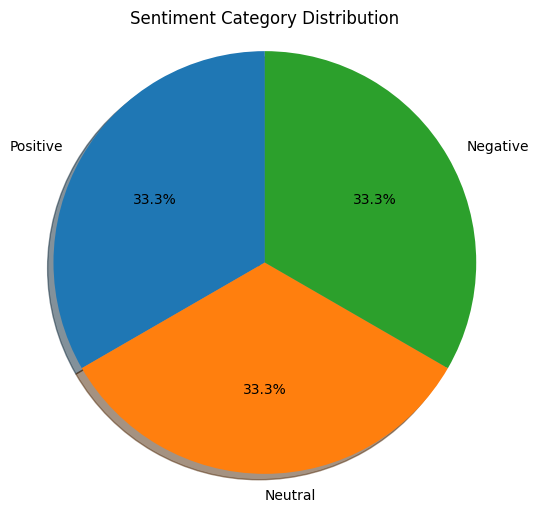

In [15]:
import matplotlib.pyplot as plt

# Data for sentiment_category value counts
sentiment_category_counts = {
    'Positive': 220797,
    'Neutral': 220797,
    'Negative': 220797
}

# Create pie chart
labels = sentiment_category_counts.keys()
sizes = sentiment_category_counts.values()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Sentiment Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [16]:
import pandas as pd

# Example DataFrames (replace with your actual DataFrames)
df1 = pd.DataFrame({
    'ID': [1, 2, 3],
    'Name': ['Alice', 'Bob', 'Charlie'],
    'Score': [85, 90, 95]
})

df2 = pd.DataFrame({
    'ID': [1, 2, 3],
    'Subject': ['Math', 'Science', 'History'],
    'Grade': ['A', 'B+', 'A-']
})

# Merge the two DataFrames on the 'ID' column (adjust based on your columns)
merged_df = pd.merge(df1, df2, on='ID')

# Save the merged DataFrame as a CSV file
merged_df.to_csv('merged_output.csv', index=False)

print("The DataFrames have been successfully merged and saved as 'merged_output.csv'.")

The DataFrames have been successfully merged and saved as 'merged_output.csv'.
